In [209]:
# mark_start = '<start> '
# mark_end = ' <end>'
# sp = []
# for line in tqdm(df[df.columns[1]]):
#     output_sentence =  mark_start +  line + mark_end
#     sp.append(output_sentence)

# en = []
# for line in tqdm(df[df.columns[0]]):
#     output_sentence =  mark_start +  line + mark_end
#     en.append(output_sentence)


# en = [[preprocess_sentence(w) for w in l.split('\t')] for l in en]
# sp = [[preprocess_sentence(w) for w in l.split('\t')]  for l in sp]

# en = tuple([i[0] for i in en])
# sp = tuple([i[0] for i in sp])

# numberOfHindiCharacters = 128;
# unicodeShift = 0x0900;
# hindiAlphabet = [];
# for i in range(numberOfHindiCharacters):
#     print(unicodedata.normalize('NFKD', "\\u0"+str(unicodeShift + i)))
# #     hindiAlphabet.appned("\\u0" + (unicodeShift + i).toString(16))


# # Download the file
# path_to_zip = tf.keras.utils.get_file(
#     'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
#     extract=True)

# path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

In [187]:
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

In [214]:
df = pd.read_csv('../data_text/pmindia.v1.hi-en.tsv', sep = '\t', header =0, encoding='utf-8')

In [206]:
en_org = df[df.columns[0]]
sp_org = df[df.columns[1]]

In [244]:
def unicode_to_ascii(s):
    s = ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')
#     print(f'unicode_to_ascii >> {s}')
#     print()
    return s


def preprocess_sentence(w):
#     print(f'preprocess_sentence input >> {w}')
    
#     print()
    w = w.lower().strip()
    w = re.sub('\u200d', '', w)
    w = re.sub(r"([?.!,¿।])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
#     w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w = w.strip()
    w = '<start> ' + w + ' <end>'
                        
#     print(f'preprocess_sentence output >> {w}')
#     print()
    
    return w


In [245]:
def create_dataset(zipped_data, num_examples):
    lines = list(zipped_data)
#     print(lines[-10])
#     print(f'org data for create_dataset is >> {lines[:num_examples]}')
#     print()
    word_pairs = [[preprocess_sentence(w) for w in l]  for l in lines[:num_examples]]

    return zip(*word_pairs)

In [261]:
num_examples = 200
en, sp = create_dataset(zip(en_org,sp_org), None)
print(en[-10])
print(sp[-10])

<start> commissioners of east , north and south municipal corporations of delhi; <end>
<start> दिल्ली के पूर्वी , उत्तरी और दक्षिणी नगर निगमों के आयुक्त; <end>


In [262]:
print(en[-189])
print(sp[-189])

<start> the prime minister suggested that there should be a common school syllabus on environmental subjects across the world , both in developed and developing countries , so that the younger generation grows up with common goals in the battle against climate change . <end>
<start> प्रधानमंत्री ने सुझाव दिया कि विश्व भर में विकसित और विकासशील देशों में पर्यावरण से जुड़े विषयों पर साझा स्कूल पाठ्यक्रम होना चाहिए ताकि जलवायु परिवर्तन के विरुद्ध संघर्ष में साझा लक्ष्यों के साथ युवा पीढ़ी का विकास हो । <end>


In [263]:
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"
print(preprocess_sentence(en_org[20]))
print(preprocess_sentence(sp_org[20]))

<start> he said the house has an opportunity to leave behind many old traditions , and establish new ones . <end>
<start> उन्होंने कहा कि सदन के पास कई पुरानी परंपराओं को छोड़कर नई परंपराएं अपनाने का मौका है । <end>


In [282]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
    lang_tokenizer.fit_on_texts(lang)

    tensor = lang_tokenizer.texts_to_sequences(lang)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,padding='post')

    return tensor, lang_tokenizer

def load_dataset(data, num_examples):
    # creating cleaned input, output pairs
    targ_lang, inp_lang = create_dataset(data, num_examples)

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer
def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, lang.index_word[t]))

In [285]:
# Try experimenting with the size of that dataset
# num_examples = len(en)
num_examples = 400

input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(zip(en_org,sp_org), num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [286]:
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

320 320 80 80


In [287]:
len(en), len(sp)

(56830, 56830)

In [288]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[-10])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[-10])

Input Language; index to word mapping
2 ----> <start>
501 ----> एनसीएमसी
26 ----> एक
1234 ----> बहुस्तरीय
502 ----> समन्वय
114 ----> केंद्र
9 ----> है
363 ----> जिसे
1235 ----> आपात
364 ----> स्थिति
1 ----> के
91 ----> दौरान
1236 ----> अंतर-एजेंसी
502 ----> समन्वय
69 ----> प्रदान
21 ----> करने
8 ----> और
38 ----> लोगों
7 ----> को
365 ----> खतरे
1 ----> के
135 ----> प्रति
1237 ----> अलर्ट
21 ----> करने
1 ----> के
16 ----> लिए
1238 ----> डिजाइन
24 ----> किया
86 ----> गया
9 ----> है
4 ----> ।
3 ----> <end>

Target Language; index to word mapping
3 ----> <start>
1 ----> the
418 ----> ncmc
18 ----> is
11 ----> a
1243 ----> multi
419 ----> level
420 ----> coordination
201 ----> centre
659 ----> designed
8 ----> to
65 ----> provide
1244 ----> inter-agency
420 ----> coordination
7 ----> and
660 ----> alert
1 ----> the
46 ----> people
137 ----> about
1 ----> the
421 ----> threat
6 ----> of
1245 ----> emergency
1246 ----> situations
2 ----> .
4 ----> <end>


In [289]:
max_length_targ, max_length_inp

(87, 92)

In [290]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [291]:
vocab_inp_size, vocab_tar_size, BUFFER_SIZE, steps_per_epoch

(2061, 2155, 320, 5)

In [292]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 92]), TensorShape([64, 87]))

In [293]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [294]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 92, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [295]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [296]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 92, 1)


In [297]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # used for attention
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

In [298]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 2155)


In [299]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [300]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [301]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(targ[:, t], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [302]:
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                       batch,
                                                       batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.8900
Epoch 1 Loss 1.9228
Time taken for 1 epoch 167.7917618751526 sec

Epoch 2 Batch 0 Loss 1.7170
Epoch 2 Loss 1.6323
Time taken for 1 epoch 62.44920325279236 sec

Epoch 3 Batch 0 Loss 1.6377
Epoch 3 Loss 1.6366
Time taken for 1 epoch 61.812910318374634 sec

Epoch 4 Batch 0 Loss 1.5378
Epoch 4 Loss 1.5720
Time taken for 1 epoch 63.83378887176514 sec

Epoch 5 Batch 0 Loss 1.5536
Epoch 5 Loss 1.5192
Time taken for 1 epoch 61.66123414039612 sec

Epoch 6 Batch 0 Loss 1.6001
Epoch 6 Loss 1.5153
Time taken for 1 epoch 63.82371282577515 sec

Epoch 7 Batch 0 Loss 1.3534
Epoch 7 Loss 1.4966
Time taken for 1 epoch 61.68086123466492 sec

Epoch 8 Batch 0 Loss 1.4945
Epoch 8 Loss 1.4836
Time taken for 1 epoch 63.53247284889221 sec

Epoch 9 Batch 0 Loss 1.3786
Epoch 9 Loss 1.4654
Time taken for 1 epoch 61.53905248641968 sec

Epoch 10 Batch 0 Loss 1.4645
Epoch 10 Loss 1.4443
Time taken for 1 epoch 62.21631383895874 sec



In [303]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot


# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [304]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [305]:
en[-10], sp[-10]

('<start> commissioners of east , north and south municipal corporations of delhi; <end>',
 '<start> दिल्ली के पूर्वी , उत्तरी और दक्षिणी नगर निगमों के आयुक्त; <end>')

Input: <start> <start> इस तरह आरएएन का कामकाज स्वास्थ्य एवं परिवार कल्याण विभाग के अधीन लाया जाएगा । <end> <end>
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


/anaconda/envs/text/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
/anaconda/envs/text/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
/anaconda/envs/text/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 2310 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/anaconda/envs/text/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 2341 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/anaconda/envs/text/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 2339 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/anaconda/envs/text/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 2309 missing from current font.
  font.set_text(s, 0.0,

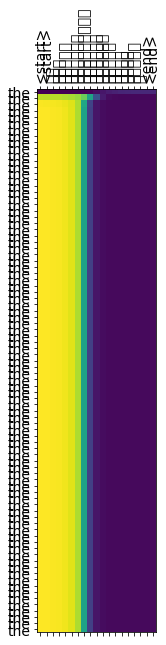

In [308]:
sent =  '<start> पर्यटन से संबंधित सूचनाओं और जानकारियों (डेटा) का आदान प्रदान । <end>'
translate(sp[1])